In [ ]:
!pip install ultralytics==8.0.20


from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Panto_2.v2i.yolov8-obb

/content/drive/MyDrive/Panto_2.v2i.yolov8-obb


In [ ]:
%cd /content/drive/MyDrive/Panto_2.v2i.yolov8-obb

!yolo task=detect mode=train model=yolov8n.pt data=data.yaml epochs=10 imgsz=640 plots=True

/content/drive/MyDrive/Panto_2.v2i.yolov8-obb
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dyna

In [ ]:
%cd /content/drive/MyDrive/Pantograph.v1i.yolov8

/content/drive/MyDrive/Pantograph.v1i.yolov8


In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/Pantograph.v3i.yolov8/runs/detect/train/weights/best.pt source='/content/drive/MyDrive/Panto_2(1).mp4' save=True save_txt=True

2024-06-24 06:27:22.947459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 06:27:22.947521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 06:27:23.017893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 06:27:23.026093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 06:27:24.214603: W tensorflow/compiler/tf2

In [ ]:
import cv2
import numpy as np
import csv
from ultralytics import YOLO

# Paths
model_path = '/content/drive/MyDrive/Panto_2.v1i.yolov8-obb/runs/detect/train2/weights/best.pt'
input_video_path = '/content/drive/MyDrive/Contact_Point_Detection_2.v2i.yolov8/videoplayback.mp4'
output_video_path = '/content/drive/MyDrive/Contact_Point_Detection_2.v2i.yolov8/spark_3_output.mp4'
csv_output_path = '/content/drive/MyDrive/Contact_Point_Detection_2.v2i.yolov8/spark_3_data.csv'

# Initialize YOLO model
model = YOLO(model_path)

# Initialize video capture and writer
cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Variables for tracking movements and previous positions
frame_count = 0
previous_pantograph_center = None
horizontal_movement = 0
vertical_movement = 0
last_recorded_time = -1

# CSV file setup
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp (s)', 'Horizontal Movement (px)', 'Vertical Movement (px)', 'Spark Detected'])

# Utility functions
def find_contact_points(line, box):
    x1, y1, x2, y2 = box
    box_lines = [
        [(x1, y1), (x2, y1)],
        [(x2, y1), (x2, y2)],
        [(x2, y2), (x1, y2)],
        [(x1, y2), (x1, y1)]
    ]
    contact_points = []
    for box_line in box_lines:
        intersection = line_intersection(line, box_line)
        if intersection and x1 <= intersection[0] <= x2 and y1 <= intersection[1] <= y2:
            contact_points.append(intersection)
    return contact_points

def line_intersection(line1, line2):
    def line_eq(p1, p2):
        A = p1[1] - p2[1]
        B = p2[0] - p1[0]
        C = p1[0] * p2[1] - p2[0] * p1[1]
        return A, B, -C

    p1, p2 = line1
    q1, q2 = line2
    L1 = line_eq(p1, p2)
    L2 = line_eq(q1, q2)
    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)
    return None

def get_color(index):
    np.random.seed(index)
    return tuple(np.random.randint(0, 256, 3).tolist())

def detect_sparks(frame, pantograph_box):
    """
    Detect sparks using image processing techniques.
    """
    spark_detected = False

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to isolate bright areas
    _, thresh = cv2.threshold(gray_frame, 200, 255, cv2.THRESH_BINARY)

    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilated = cv2.dilate(thresh, kernel, iterations=2)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours within the pantograph box
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        spark_center = (x + w // 2, y + h // 2)

        if pantograph_box[0] <= spark_center[0] <= pantograph_box[2] and pantograph_box[1] <= spark_center[1] <= pantograph_box[3]:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw a green rectangle for sparks
            spark_detected = True

    return spark_detected

# Main loop for processing video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    pantograph_box = None
    pantobar_box = None
    cable_boxes = []
    contact_points_distances = []

    # Loop through detected objects
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if class_id == 2:  # Pantograph class ID
                pantograph_box = (x1, y1, x2, y2)
            elif class_id == 1:  # Pantobar class ID
                pantobar_box = (x1, y1, x2, y2)
            elif class_id == 0:  # Cable class ID
                cable_boxes.append((x1, y1, x2, y2))

    if pantograph_box is not None:
        px1, py1, px2, py2 = pantograph_box
        pantograph_height = py2 - py1
        pantograph_height_text = f'Pantograph Height: {pantograph_height}px'
        cv2.putText(frame, pantograph_height_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        pantograph_center = ((px1 + px2) // 2, (py1 + py2) // 2)

        if previous_pantograph_center is not None:
            dx = pantograph_center[0] - previous_pantograph_center[0]
            dy = pantograph_center[1] - previous_pantograph_center[1]
            horizontal_movement += dx
            vertical_movement += dy

        previous_pantograph_center = pantograph_center

        # Detect sparks within the pantograph box
        spark_detected = detect_sparks(frame, pantograph_box)

    if pantobar_box is not None:
        bx1, by1, bx2, by2 = pantobar_box
        cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0, 255, 255), 2)
        pantobar_top_line = [(bx1, by1), (bx2, by1)]
        cv2.line(frame, pantobar_top_line[0], pantobar_top_line[1], (255, 0, 0), 2)
        center_point = ((bx1 + bx2) // 2, by1)

        for i, cable_box in enumerate(cable_boxes):
            cx1, cy1, cx2, cy2 = cable_box
            cv2.rectangle(frame, (cx1, cy1), (cx2, cy2), (0, 0, 255), 2)
            contact_points = find_contact_points(pantobar_top_line, cable_box)

            if contact_points:
                mid_x = sum(p[0] for p in contact_points) // len(contact_points)
                mid_y = sum(p[1] for p in contact_points) // len(contact_points)
                midpoint = (mid_x, mid_y)
                color = get_color(i)
                cv2.circle(frame, midpoint, 6, color, -1)

                line_length = bx2 - bx1
                distance_meters = (np.linalg.norm(np.array(midpoint) - np.array(center_point)) / line_length) * 3
                contact_points_distances.append((distance_meters, color))

        for i, (distance, color) in enumerate(contact_points_distances):
            distance_text = f'CP{i+1}: {distance:.2f}m'
            cv2.putText(frame, distance_text, (10, 60 + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    movement_text = f'Horizontal Movement: {horizontal_movement}px, Vertical Movement: {vertical_movement}px'
    cv2.putText(frame, movement_text, (10, frame_height - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000

    if int(current_time) > last_recorded_time:
        with open(csv_output_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([int(current_time), horizontal_movement, vertical_movement, spark_detected])
        last_recorded_time = int(current_time)

    out.write(frame)
    frame_count += 1

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


In [ ]:
import cv2
import numpy as np
import csv
from ultralytics import YOLO

# Load the YOLOv8 model from a local file
model_path = '/content/drive/MyDrive/Panto_2.v1i.yolov8-obb/runs/detect/train2/weights/best.pt'
model = YOLO(model_path)

# Paths
input_video_path = '/path_to_your_input_video.mp4'
output_video_path = '/path_to_your_output_video.mp4'
csv_output_path = '/path_to_your_csv_output.csv'

# Open the video
cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_count = 0
previous_pantograph_center = None
horizontal_movement = 0
vertical_movement = 0
last_recorded_time = -1  # Track the last recorded timestamp

# Initialize CSV file
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp (s)', 'Horizontal Movement (px)', 'Vertical Movement (px)', 'Sparks Detected'])

def find_contact_points(line, box):
    x1, y1, x2, y2 = box
    box_lines = [
        [(x1, y1), (x2, y1)],  # top
        [(x2, y1), (x2, y2)],  # right
        [(x2, y2), (x1, y2)],  # bottom
        [(x1, y2), (x1, y1)]   # left
    ]
    contact_points = []
    for box_line in box_lines:
        intersection = line_intersection(line, box_line)
        if intersection and x1 <= intersection[0] <= x2 and y1 <= intersection[1] <= y2:
            contact_points.append(intersection)
    return contact_points

def line_intersection(line1, line2):
    def line_eq(p1, p2):
        A = p1[1] - p2[1]
        B = p2[0] - p1[0]
        C = p1[0] * p2[1] - p2[0] * p1[1]
        return A, B, -C

    p1, p2 = line1
    q1, q2 = line2
    L1 = line_eq(p1, p2)
    L2 = line_eq(q1, q2)
    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)
    return None

def get_color(index):
    np.random.seed(index)
    return tuple(np.random.randint(0, 256, 3).tolist())

def detect_sparks(frame, pantobar_box):
    bx1, by1, bx2, by2 = pantobar_box
    pantobar_region = frame[by1:by2, bx1:bx2]
    gray = cv2.cvtColor(pantobar_region, cv2.COLOR_BGR2GRAY)
    _, bright_spots = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(bright_spots, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sparks = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        spark_center = (x + w // 2 + bx1, y + h // 2 + by1)
        if cv2.contourArea(cnt) > 5:  # Filter small noise
            sparks.append(spark_center)
            cv2.circle(frame, spark_center, 5, (0, 255, 255), -1)
    return sparks

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 inference on the frame
    results = model(frame)

    pantograph_box = None
    pantobar_box = None
    cable_boxes = []
    contact_points_distances = []
    sparks_detected = 0

    # Parse the results
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if class_id == 2:  # Pantograph class ID
                pantograph_box = (x1, y1, x2, y2)
            elif class_id == 1:  # Pantobar class ID
                pantobar_box = (x1, y1, x2, y2)
            elif class_id == 0:  # Cable class ID
                cable_boxes.append((x1, y1, x2, y2))

    if pantograph_box is not None:
        # Calculate and display the height of the pantograph
        px1, py1, px2, py2 = pantograph_box
        pantograph_height = py2 - py1
        pantograph_height_text = f'Pantograph Height: {pantograph_height}px'
        cv2.putText(frame, pantograph_height_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Calculate the center point of the pantograph box
        pantograph_center = ((px1 + px2) // 2, (py1 + py2) // 2)

        # Calculate movement if previous center exists
        if previous_pantograph_center is not None:
            dx = pantograph_center[0] - previous_pantograph_center[0]
            dy = pantograph_center[1] - previous_pantograph_center[1]
            horizontal_movement += dx
            vertical_movement += dy

        previous_pantograph_center = pantograph_center

    if pantobar_box is not None:
        bx1, by1, bx2, by2 = pantobar_box

        # Draw the pantobar bounding box
        cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0, 255, 255), 2)

        # Draw the blue line on top of the pantobar
        pantobar_top_line = [(bx1, by1), (bx2, by1)]
        cv2.line(frame, pantobar_top_line[0], pantobar_top_line[1], (255, 0, 0), 2)

        # Calculate the center point of the blue line
        center_point = ((bx1 + bx2) // 2, by1)

        # Find and mark contact points with cable boxes
        for i, cable_box in enumerate(cable_boxes):
            cx1, cy1, cx2, cy2 = cable_box

            # Draw the cable bounding box
            cv2.rectangle(frame, (cx1, cy1), (cx2, cy2), (0, 0, 255), 2)

            # Find contact points between the pantobar top line and the cable box
            contact_points = find_contact_points(pantobar_top_line, cable_box)

            if contact_points:
                # Compute the midpoint of the contact points
                mid_x = sum(p[0] for p in contact_points) // len(contact_points)
                mid_y = sum(p[1] for p in contact_points) // len(contact_points)
                midpoint = (mid_x, mid_y)

                # Generate a color for this contact point
                color = get_color(i)

                # Draw the contact point
                cv2.circle(frame, midpoint, 6, color, -1)

                # Calculate distance from the center point (assuming 3 meters is the length of the line)
                line_length = bx2 - bx1
                distance_meters = (np.linalg.norm(np.array(midpoint) - np.array(center_point)) / line_length) * 3
                contact_points_distances.append((distance_meters, color))

        # Display the distances in the corner of the video
        for i, (distance, color) in enumerate(contact_points_distances):
            distance_text = f'CP{i+1}: {distance:.2f}m'
            cv2.putText(frame, distance_text, (10, 60 + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Detect sparks within the pantobar bounding box
        sparks = detect_sparks(frame, pantobar_box)
        sparks_detected = len(sparks)

    # Display the movement in the bottom left corner of the video
    movement_text = f'Horizontal Movement: {horizontal_movement}px, Vertical Movement: {vertical_movement}px'
    cv2.putText(frame, movement_text, (10, frame_height - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Get the current timestamp in seconds
    current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000

    # Write to CSV file every second
    if int(current_time) > last_recorded_time:
        with open(csv_output_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([int(current_time), horizontal_movement, vertical_movement, sparks_detected])
        last_recorded_time = int(current_time)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()
cv2.destroyAllWindows()

# Display the final output video
from IPython.display import Video
Video(output_video_path, embed=True)


In [ ]:
!pip install ultralytics opencv-python-headless

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
import base64

def capture_image():
    js = Javascript('''
        async function capture() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getVideoTracks()[0].stop();
            video.remove();

            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('capture()')
    return data

def data_uri_to_cv2_img(uri):
    nparr = np.frombuffer(base64.b64decode(uri.split(',')[1]), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img


<IPython.core.display.Javascript object>

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


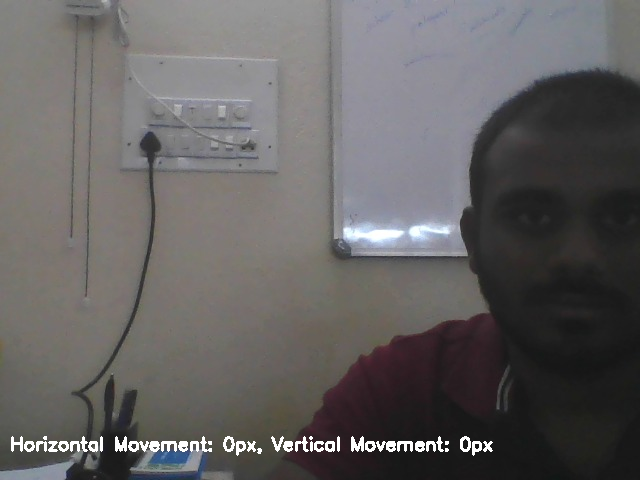

<IPython.core.display.Javascript object>

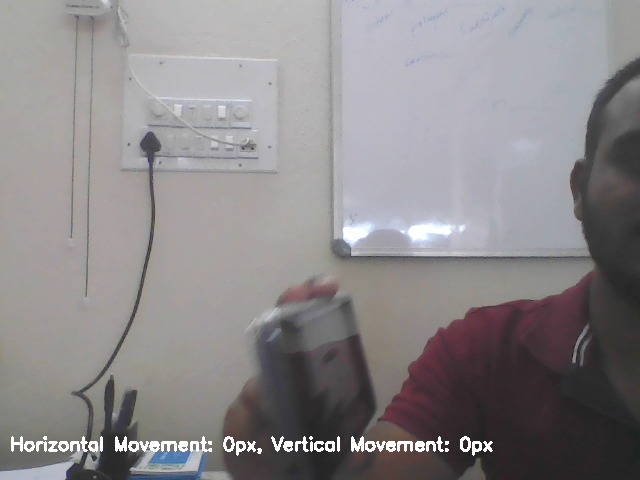

<IPython.core.display.Javascript object>

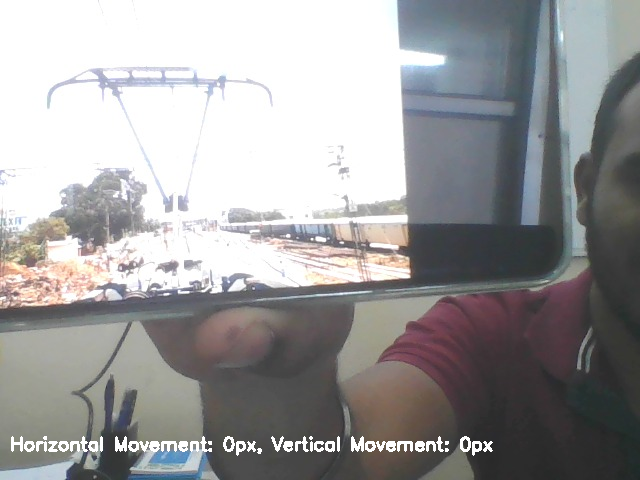

<IPython.core.display.Javascript object>

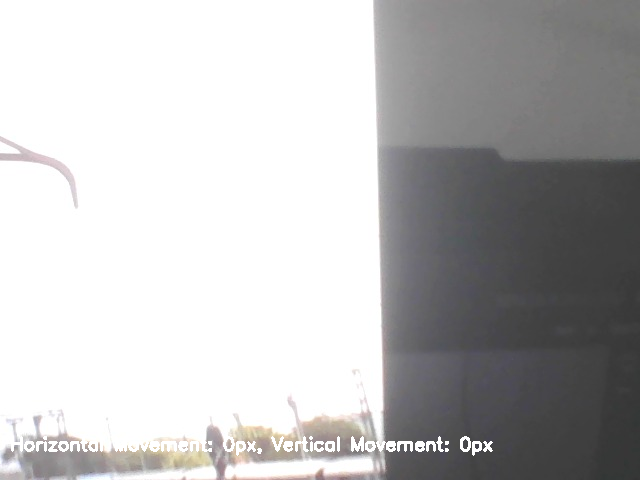

<IPython.core.display.Javascript object>

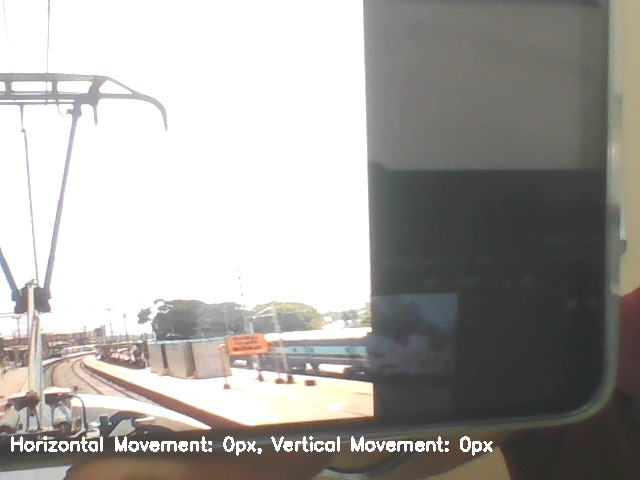

<IPython.core.display.Javascript object>

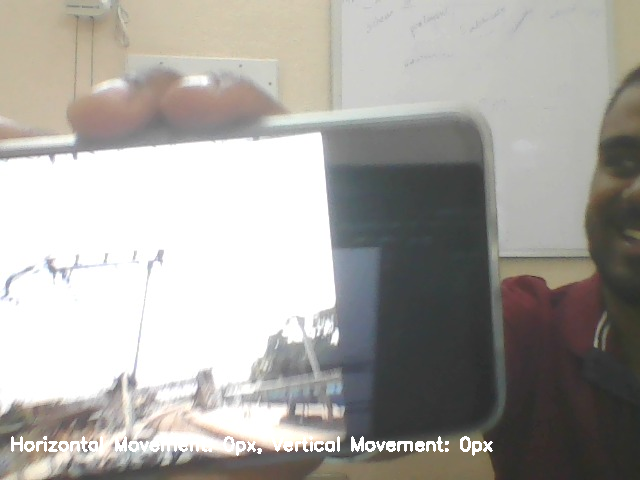

<IPython.core.display.Javascript object>

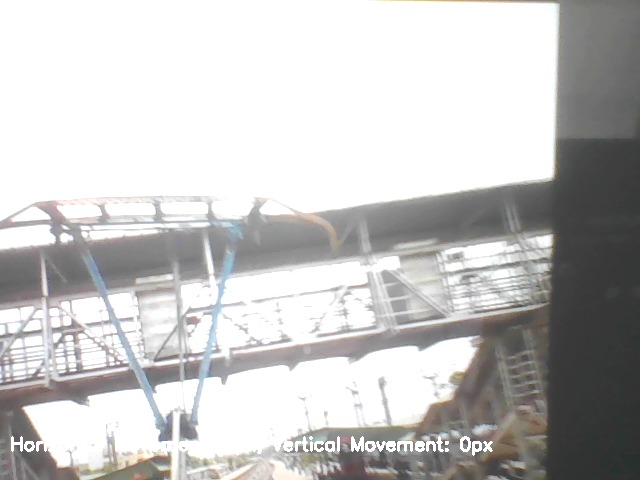

<IPython.core.display.Javascript object>

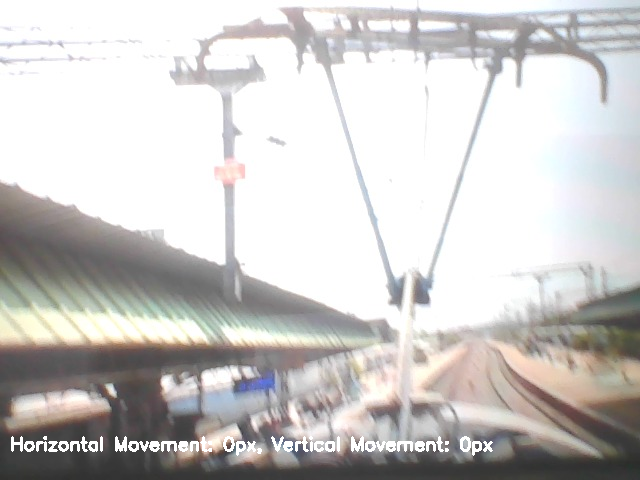

<IPython.core.display.Javascript object>

WARNING ⚠️ NMS time limit 0.550s exceeded


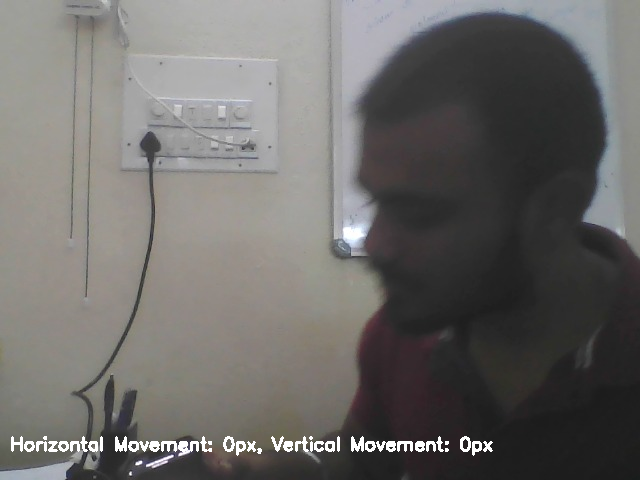

<IPython.core.display.Javascript object>

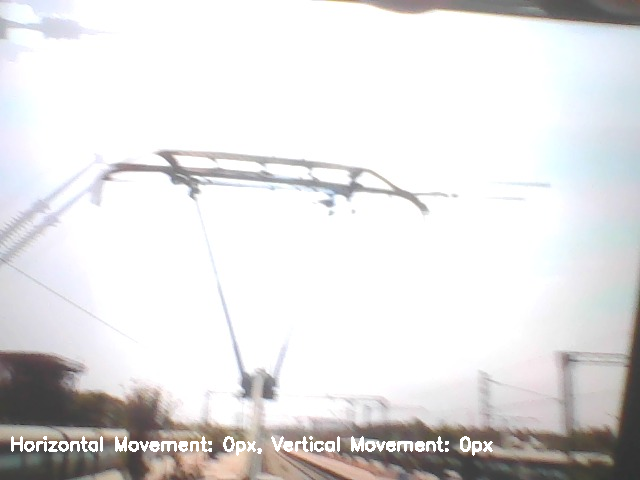

<IPython.core.display.Javascript object>

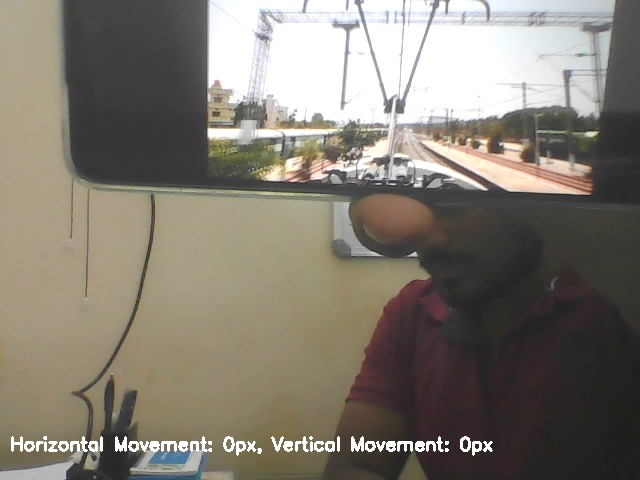

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import csv
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import base64
import time

# Load the YOLOv8 model from a local file
model_path = '/content/drive/MyDrive/Panto_2.v2i.yolov8-obb/runs/detect/train3/weights/best.pt'
model = YOLO(model_path)

# Paths
csv_output_path = '/content/drive/MyDrive/Panto_2.v1i.yolov8-obb/movement_data_5.csv'

frame_count = 0
previous_pantograph_center = None
horizontal_movement = 0
vertical_movement = 0
last_recorded_time = -1  # Track the last recorded timestamp

# Initialize CSV file
with open(csv_output_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp (s)', 'Horizontal Movement (px)', 'Vertical Movement (px)'])

def find_contact_points(line, box):
    x1, y1, x2, y2 = box
    box_lines = [
        [(x1, y1), (x2, y1)],  # top
        [(x2, y1), (x2, y2)],  # right
        [(x2, y2), (x1, y2)],  # bottom
        [(x1, y2), (x1, y1)]   # left
    ]
    contact_points = []
    for box_line in box_lines:
        intersection = line_intersection(line, box_line)
        if intersection and x1 <= intersection[0] <= x2 and y1 <= intersection[1] <= y2:
            contact_points.append(intersection)
    return contact_points

def line_intersection(line1, line2):
    def line_eq(p1, p2):
        A = p1[1] - p2[1]
        B = p2[0] - p1[0]
        C = p1[0] * p2[1] - p2[0] * p1[1]
        return A, B, -C

    p1, p2 = line1
    q1, q2 = line2
    L1 = line_eq(p1, p2)
    L2 = line_eq(q1, q2)
    D = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)
    return None

def get_color(index):
    np.random.seed(index)
    return tuple(np.random.randint(0, 256, 3).tolist())

def capture_image():
    js = Javascript('''
        async function capture() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');

            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            stream.getVideoTracks()[0].stop();
            video.remove();

            return canvas.toDataURL('image/jpeg');
        }
    ''')
    display(js)
    data = eval_js('capture()')
    return data

def data_uri_to_cv2_img(uri):
    nparr = np.frombuffer(base64.b64decode(uri.split(',')[1]), np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return img

while True:
    # Capture an image from the webcam
    image_data = capture_image()
    frame = data_uri_to_cv2_img(image_data)

    # Run YOLOv8 inference on the frame
    results = model(frame)

    pantograph_box = None
    pantobar_box = None
    cable_boxes = []
    contact_points_distances = []

    # Parse the results
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            if class_id == 2:  # Pantograph class ID
                pantograph_box = (x1, y1, x2, y2)
            elif class_id == 1:  # Pantobar class ID
                pantobar_box = (x1, y1, x2, y2)
            elif class_id == 0:  # Cable class ID
                cable_boxes.append((x1, y1, x2, y2))

    if pantograph_box is not None:
        # Calculate and display the height of the pantograph
        px1, py1, px2, py2 = pantograph_box
        pantograph_height = py2 - py1
        pantograph_height_text = f'Pantograph Height: {pantograph_height}px'
        cv2.putText(frame, pantograph_height_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Calculate the center point of the pantograph box
        pantograph_center = ((px1 + px2) // 2, (py1 + py2) // 2)

        # Calculate movement if previous center exists
        if previous_pantograph_center is not None:
            dx = pantograph_center[0] - previous_pantograph_center[0]
            dy = pantograph_center[1] - previous_pantograph_center[1]
            horizontal_movement += dx
            vertical_movement += dy

        previous_pantograph_center = pantograph_center

    if pantobar_box is not None:
        bx1, by1, bx2, by2 = pantobar_box

        # Draw the pantobar bounding box
        cv2.rectangle(frame, (bx1, by1), (bx2, by2), (0, 255, 255), 2)

        # Draw the blue line on top of the pantobar
        pantobar_top_line = [(bx1, by1), (bx2, by1)]
        cv2.line(frame, pantobar_top_line[0], pantobar_top_line[1], (255, 0, 0), 2)

        # Calculate the center point of the blue line
        center_point = ((bx1 + bx2) // 2, by1)

        # Find and mark contact points with cable boxes
        for i, cable_box in enumerate(cable_boxes):
            cx1, cy1, cx2, cy2 = cable_box

            # Draw the cable bounding box
            cv2.rectangle(frame, (cx1, cy1), (cx2, cy2), (0, 0, 255), 2)

            # Find contact points between the pantobar top line and the cable box
            contact_points = find_contact_points(pantobar_top_line, cable_box)

            if contact_points:
                # Compute the midpoint of the contact points
                mid_x = sum(p[0] for p in contact_points) // len(contact_points)
                mid_y = sum(p[1] for p in contact_points) // len(contact_points)
                midpoint = (mid_x, mid_y)

                # Generate a color for this contact point
                color = get_color(i)

                # Draw the contact point
                cv2.circle(frame, midpoint, 6, color, -1)

                # Calculate distance from the center point (assuming 3 meters is the length of the line)
                line_length = bx2 - bx1
                distance_meters = (np.linalg.norm(np.array(midpoint) - np.array(center_point)) / line_length) * 3
                contact_points_distances.append((distance_meters, color))

        # Display the distances in the corner of the video
        for i, (distance, color) in enumerate(contact_points_distances):
            distance_text = f'CP{i+1}: {distance:.2f}m'
            cv2.putText(frame, distance_text, (10, 60 + i*30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Display the movement in the bottom left corner of the video
    movement_text = f'Horizontal Movement: {horizontal_movement}px, Vertical Movement: {vertical_movement}px'
    cv2.putText(frame, movement_text, (10, frame.shape[0] - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Get the current timestamp in seconds
    current_time = time.time()

    # Write to CSV file every second
    if int(current_time) > last_recorded_time:
        with open(csv_output_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([int(current_time), horizontal_movement, vertical_movement])
        last_recorded_time = int(current_time)

    # Display the frame in a window
    cv2_imshow(frame)

    # Exit the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cv2.destroyAllWindows()
